# Part 1

In [1]:
import pandas as pd
import numpy as np
import random
import queue
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import time
from scipy.spatial import KDTree
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
orig_data = pd.read_csv('as3_1.txt', sep='\t', names=['x','y','label'])
orig_data

,x,y,label
0,25.0514,5.7475,1
1,26.6614,7.3414,1
2,25.2653,6.2466,1
3,25.2285,4.7447,1
4,25.7529,5.1564,1
...,...,...,...
3095,5.1380,16.6150,31
3096,5.7360,16.9991,31
3097,5.2760,17.2475,31
3098,6.4444,16.2033,31


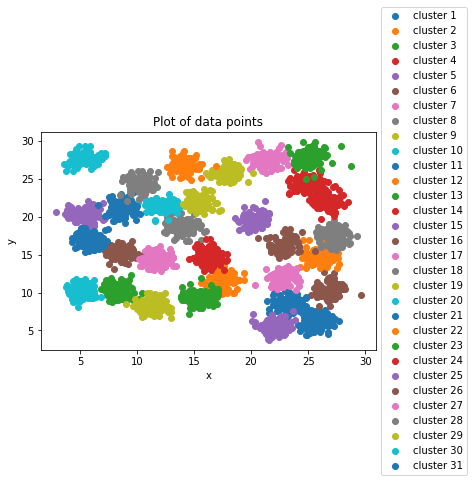

In [3]:
for target in set(orig_data.label.values):
    x = [orig_data.x[i] for i in range(len(orig_data)) if orig_data.label[i]==target]
    y = [orig_data.y[i] for i in range(len(orig_data)) if orig_data.label[i]==target]
    plt.scatter(x, y, label=f"cluster {target}")
plt.title('Plot of data points')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [4]:
data_points = np.array(orig_data.iloc[:,:-1])
n_DataPoints = data_points.shape[0]
data_points

array([[25.0514,  5.7475],
       [26.6614,  7.3414],
       [25.2653,  6.2466],
       ...,
       [ 5.276 , 17.2475],
       [ 6.4444, 16.2033],
       [ 7.162 , 18.1836]])

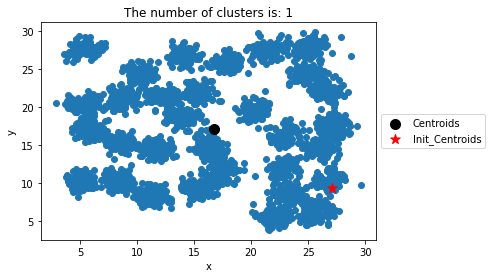

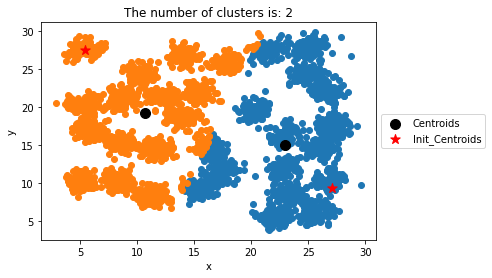

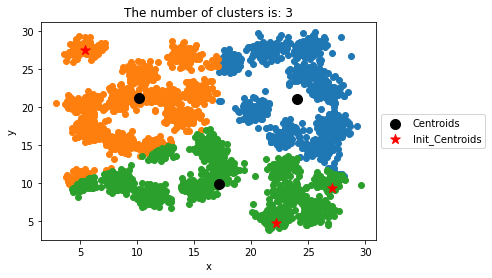

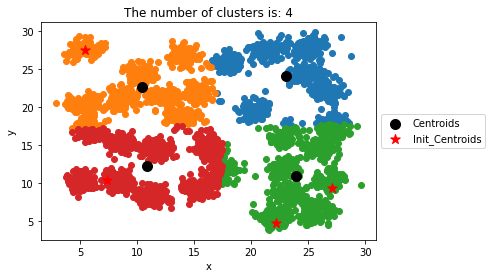

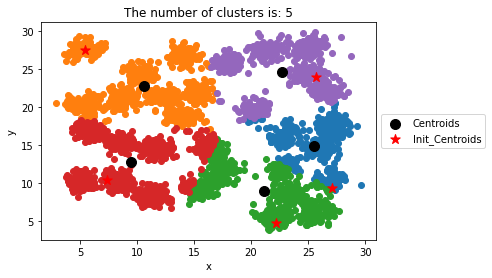

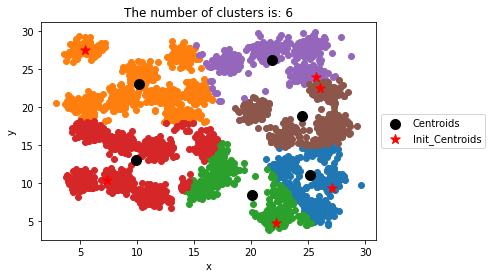

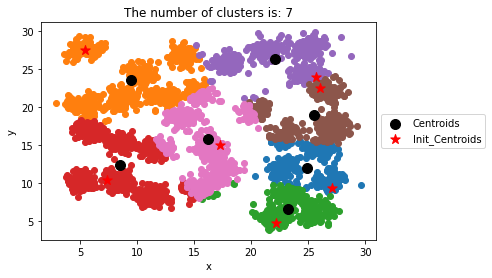

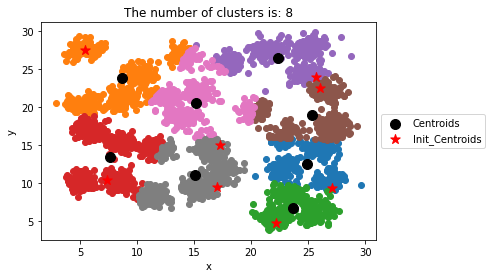

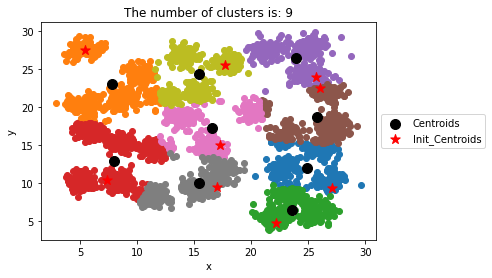

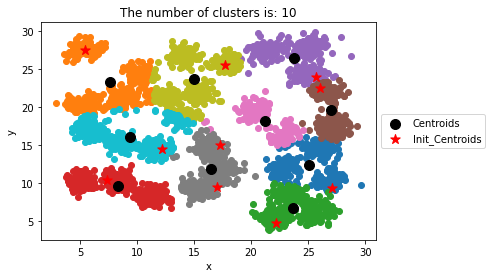

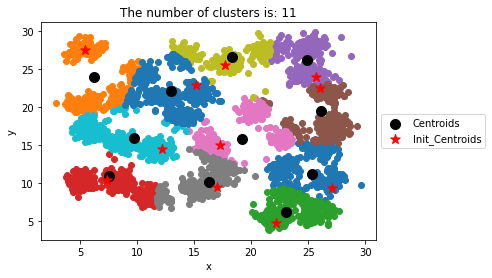

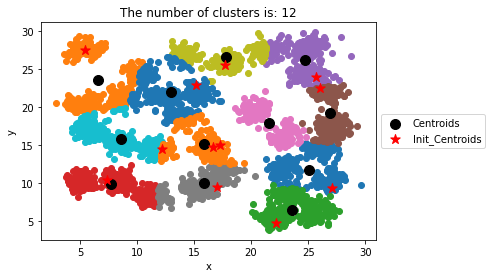

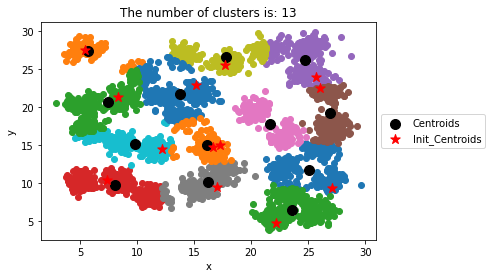

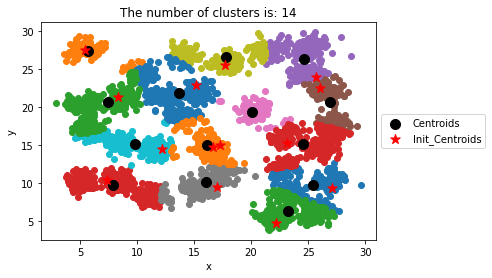

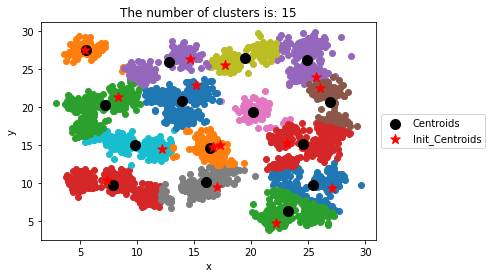

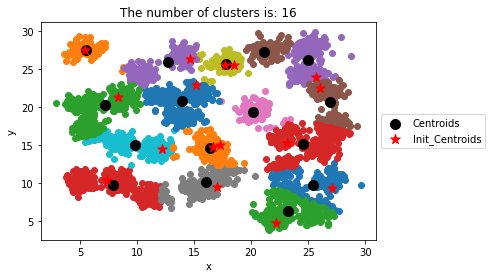

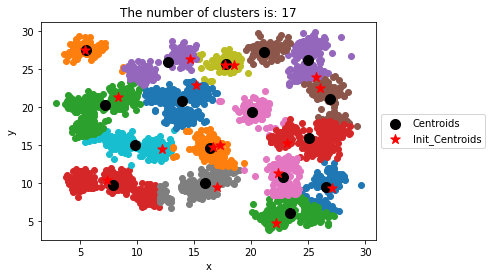

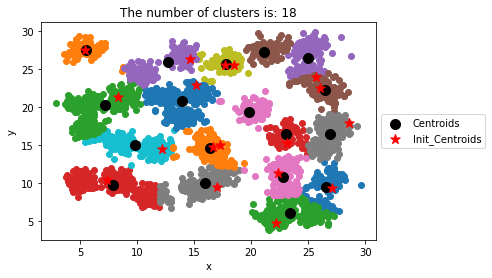

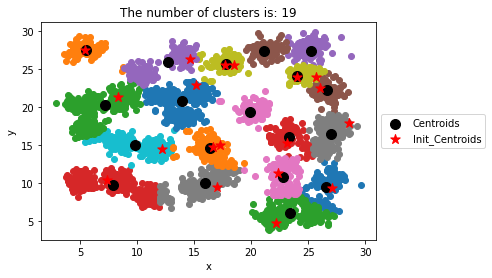

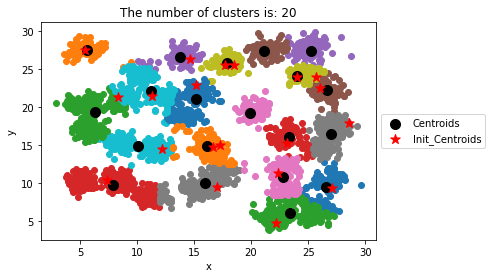

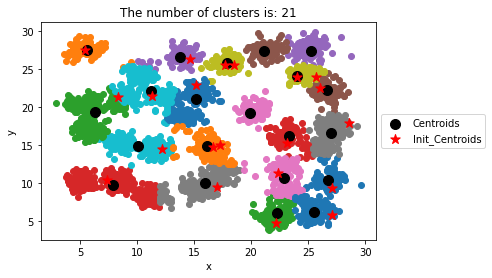

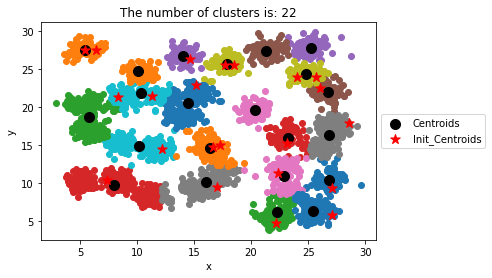

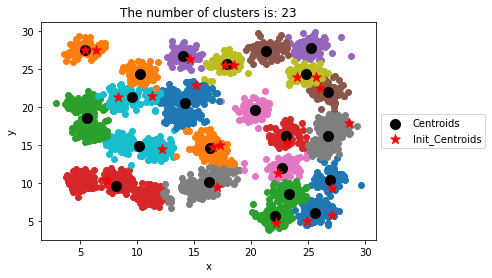

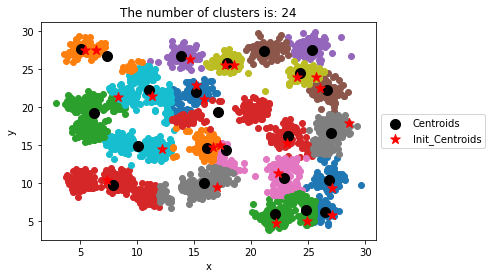

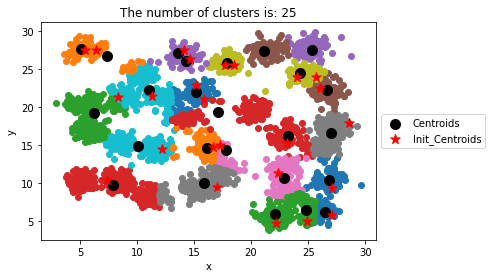

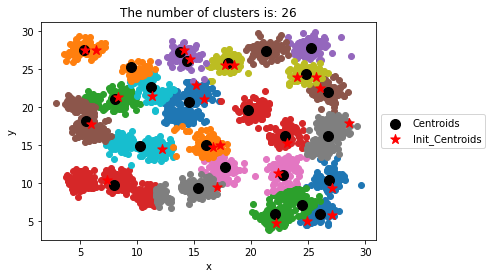

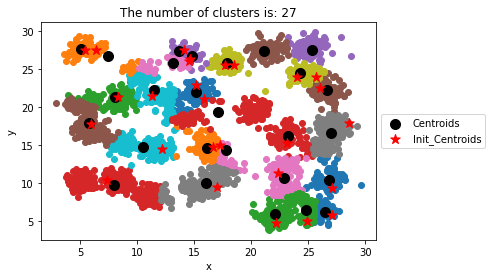

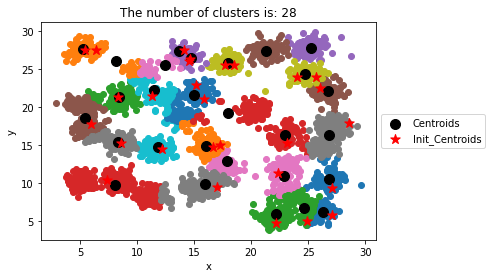

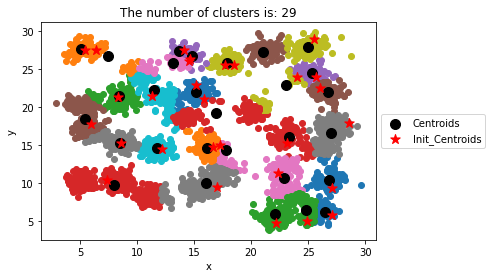

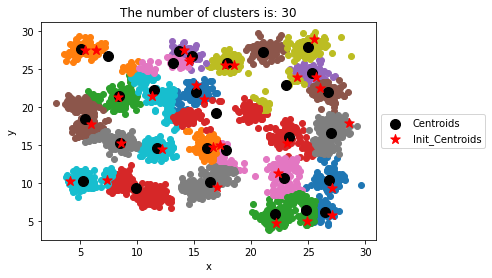

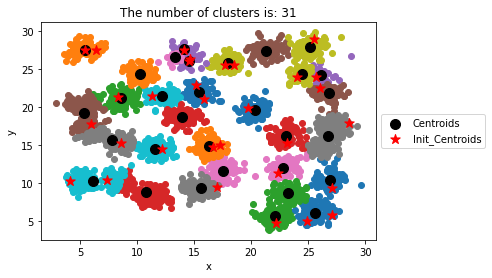

Text(0, 0.5, 'Cost')

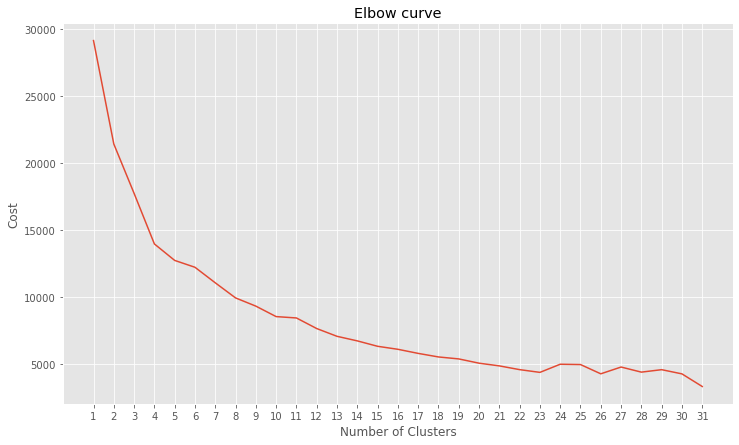

In [5]:
def myInit(K):
    # using k-means++ method to find k initial centroids
    random.seed(1)
    # randomly select the first centroid from data point
    i=random.randint(0,data_points.shape[0])
    Centroids=np.array([data_points[i]])
    for k in range(1,K):
        Distances=np.array([]) 
        # For each data point compute its distance from the nearest chosen centroid by using min of distances
        for dataPoint in data_points:
            Distances=np.append(Distances,np.min(np.sqrt(np.sum((dataPoint-Centroids)**2, axis=1))))
        prob=Distances/np.sum(Distances)   
        # Calculate the cumulative probability distribution that the range is from 0 to 1
        cummulative_prob=np.cumsum(prob)
        # Select a random number between 0 to 1
        r=random.random()
        i=0
        # get the index (i) of CPD that greater than the chosen random number and assign the data point corresponding to the selected index (i)
        for index,pb in enumerate(cummulative_prob):
            if r<pb:
                i=index # assign index to a variable to find the corresponding data point
                break
        Centroids=np.append(Centroids,[data_points[i]],axis=0)
    return Centroids.T
                                
def myAssign(EuclidianDistance):
    Cluster_array=np.argmin(EuclidianDistance,axis=1)+1 # Adding 1 get the centroid number that has the min distance from centroid to point for each point
    min_dist=EuclidianDistance.min(axis=1) # calculate the distance of each data point to the nearst centroid
    return Cluster_array,min_dist

def myCentroid(K, Centroids):
    EuclidianDistance=np.array([]).reshape(n_DataPoints,0)
    for k in range(K):
        # calculate the EuclidianDistance between data points and each centroid
        tempDist=np.sqrt(np.sum((data_points-Centroids[:,k])**2,axis=1))
        EuclidianDistance=np.c_[EuclidianDistance,tempDist]
    return EuclidianDistance

def myUpdateCentroid(K, Cluster_array, Centroids):
    # copy the previous Centroid to a new variable to avoid rewriting problem
    new_Centroids = Centroids.copy()
    cluster={}
    # create K keys in cluster dict
    for k in range(K):
        cluster[k+1]=np.array([]).reshape(2,0)
    # assign centroid and related cluster data point to dict
    for i in range(n_DataPoints):
        cluster[Cluster_array[i]]=np.c_[cluster[Cluster_array[i]],data_points[i]]
    # reshape the cluster data points in each cluster
    for k in range(K):
        cluster[k+1]=cluster[k+1].T
    # update the centroid by calculating mean in each cluster data points
    for k in range(K):
        new_Centroids[:,k]=np.mean(cluster[k+1],axis=0)
        
    return cluster, new_Centroids
    
def myPlot(K,cluster,Centroids,Init_Centroids):
    for k in range(K):
        plt.scatter(cluster[k+1][:,0],cluster[k+1][:,1])
    p1 = plt.scatter(Centroids[0,:],Centroids[1,:],s=100,c='black',label='Centroids')
    p2 = plt.scatter(Init_Centroids[0,:],Init_Centroids[1,:],s=100,c='r',label='Init_Centroids',marker='*')
    plt.title(f'The number of clusters is: {my_k}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # set the legend label out of graph
    plt.show()
    
def myKmeanPlusPlus(my_k, myTol, myMax):
    Init_Centroids = myInit(K=my_k)
    Centroids = Init_Centroids.copy()
    final_cluster = {}
    for i in range(myMax):
        EuclidianDistance = myCentroid(my_k, Centroids)
        # assign cluster array and get the distance of all data points
        Cluster_array, min_dist = myAssign(EuclidianDistance) 
        final_cluster, curr_Centroids =myUpdateCentroid(my_k, Cluster_array, Centroids)
        tol_condition = np.sum((curr_Centroids - Centroids)/Centroids * 100.0)
        if  tol_condition < myTol:
            break
        Centroids = curr_Centroids
    
    myPlot(my_k,final_cluster,Centroids,Init_Centroids)
    cost = sum(min_dist)
    return cost


# call the main function (myKmeanPlusPlus function)
k_candidate = list(np.arange(1, 32))
costs = []
for my_k in k_candidate:
    costs.append(myKmeanPlusPlus(my_k=my_k, myTol=0.0001, myMax=100))

# plot elbow curve to find optimized k
plt.style.use('ggplot')
plt.figure(figsize=(12,7))
plt.plot(k_candidate,costs)
plt.title("Elbow curve")
plt.xticks(k_candidate)
plt.xlabel("Number of Clusters")
plt.ylabel("Cost")

Now if we observe the point after which there isn’t a sudden change in elbow curve is k=4. So we choose k=4 as an appropriate number of clusters.

# Part 2

In [6]:
df_noise = pd.read_csv('as3_2.csv', names=['x','y','label'])
df_noise

,x,y,label
0,27.70,20.85,1
1,29.90,19.95,1
2,26.80,19.05,1
3,28.35,18.25,1
4,30.40,17.85,1
...,...,...,...
391,15.85,9.95,6
392,15.35,9.90,6
393,15.60,9.45,6
394,15.30,9.15,6


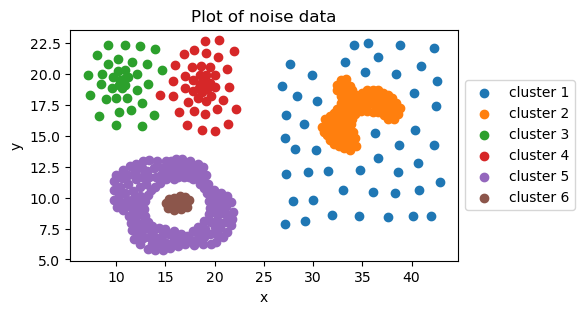

In [8]:
plt.style.use('default')
plt.figure(figsize=(5,3))
for target in set(df_noise.label.values):
    x = [df_noise.x[i] for i in range(len(df_noise)) if df_noise.label[i]==target]
    y = [df_noise.y[i] for i in range(len(df_noise)) if df_noise.label[i]==target]
    plt.scatter(x, y, label=f"cluster {target}")
plt.title('Plot of noise data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Standard DBSCAN computation time is 0.8369960784912109


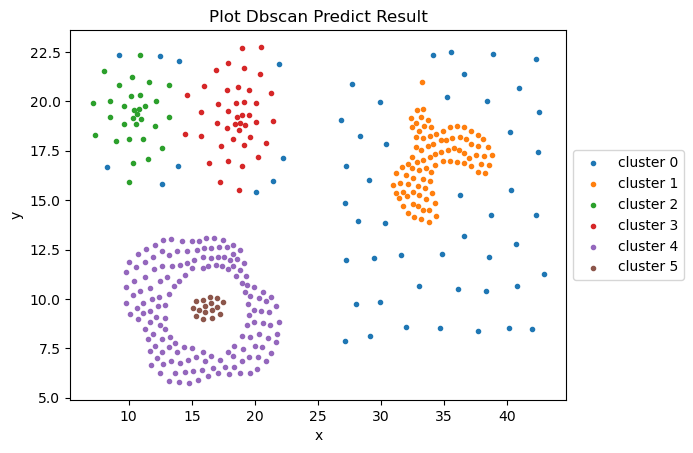

              precision    recall  f1-score   support

           1       0.82      0.98      0.89        47
           2       0.99      1.00      0.99        92
           3       1.00      0.82      0.90        38
           4       0.98      0.91      0.94        45
           5       1.00      1.00      1.00       158
           6       1.00      1.00      1.00        16

    accuracy                           0.97       396
   macro avg       0.96      0.95      0.95       396
weighted avg       0.97      0.97      0.97       396



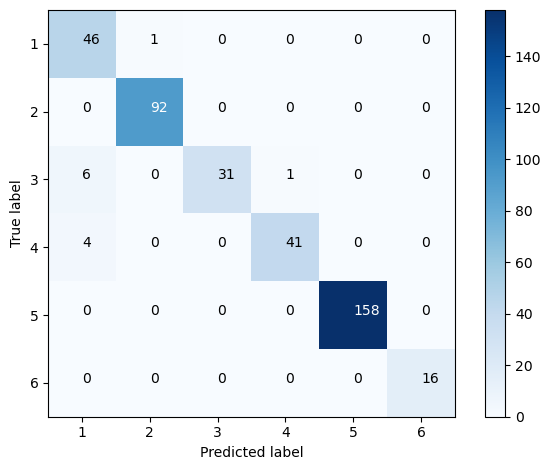

In [9]:
#Define label for three differnt point groups (core, border, noise)
unassigned_cluster = 0 # initial all unassigned points are label as noise as 0
core=-1
border=-2

def getLabel(df):
    return np.array(df.label)

def getData(df):
    return np.array(df.iloc[:,:-1])

def getDBSCAN(vectors, epsilon, minPoints):
    #initilize all pointlable to unassigned cluster as 0
    pred_label  = [unassigned_cluster] * len(vectors)
    point_neighbors = []
    #initilize list for core/noncore point
    corepoint=[]
    noncore=[]
    #Find all neigbor for all point
    for i in range(len(vectors)):
        points = []
        for j in range(len(vectors)):
            #Euclidian distance using L2 Norm to get all nearest neighbors for all points
            if np.linalg.norm(vectors[i] - vectors[j]) <= epsilon:
                points.append(j)
        point_neighbors.append(points)
    #print('point_neighbors',point_neighbors)   
    #Find all core point, borderpoint and noise
    for i in range(len(point_neighbors)):
        # if points in circle are more than min points, it has the core point
        if (len(point_neighbors[i])>=minPoints):
            pred_label[i]=core # label the core point as -1
            corepoint.append(i)
        else:
            noncore.append(i)
    # scan the values in all noncore array. If any of the values is a core point, that means the point correlated to noncore array is a border point for another core point 
    for i in noncore:
        for j in point_neighbors[i]:
            if j in corepoint:
                pred_label[i]=border # label the border point as -2, others are noise as initial 0 

                break
    #print('pred_label',pred_label)      
    
    #start assigning point to cluster
    clusters = 1
    #Using a Queue to put all neigbor core point in queue and find neigbor's neigbor
    for i in range(len(pred_label)):
        q = queue.Queue()
        if (pred_label[i] == core):
            pred_label[i] = clusters
            for x in point_neighbors[i]:
                # if the core point and neighbor point are all core point, put the neighbor point into queue
                # cluster neighbor point which is either another core point or a border point as same cluster as its core point
                if(pred_label[x]==core):
                    q.put(x)
                    pred_label[x]=clusters
                elif(pred_label[x]==border):
                    pred_label[x]=clusters
            #Stop when all point in Queue has been checked   
            while not q.empty():
                neighbors = point_neighbors[q.get()] # first in first out
                for y in neighbors:
                    if (pred_label[y]==core):
                        pred_label[y]=clusters
                        q.put(y)
                    if (pred_label[y]==border):
                        pred_label[y]=clusters            
            clusters=clusters+1 #move to next cluster
           
    return pred_label,clusters

def getAccuracy(pred_label, true_label):
    # add 1 to match the true label
    pred_label = np.array(pred_label)+1
    labels = np.unique(pred_label)
    print(classification_report(true_label, pred_label, labels)) #classification report from sklearn
    cnf_matrix = confusion_matrix(true_label, pred_label, labels=labels)
    plt.imshow(cnf_matrix, cmap=plt.cm.Blues) #plot confusion matrix grid
    threshold = cnf_matrix.max() / 2 #threshold to define text color
    for i in range(cnf_matrix.shape[0]): #print text in grid
        for j in range(cnf_matrix.shape[1]): 
            plt.text(j, i, cnf_matrix[i,j], color="w" if cnf_matrix[i,j] > threshold else 'black')
    tick_marks = np.arange(len(labels)) #define labeling spacing based on number of classes
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.tight_layout()

def plotDBSCAN(vectors, pred_label, clusters):
    nPoints = len(vectors)
    for i in range(clusters):
        x1 = []
        y1 = []
        for j in range(nPoints):
            if pred_label[j] == i:
                x1.append(vectors[j, 0])
                y1.append(vectors[j, 1])
        
        plt.scatter(x1, y1, alpha=1, marker='.', label=f"cluster {i}")
    plt.title('Plot Dbscan Predict Result')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

vectors = getData(df_noise)
epsilon = 1.5
minPoints = 5  
start = time.time()
pred_label,clusters = getDBSCAN(vectors,epsilon,minPoints)
end = time.time()
print(f'Standard DBSCAN computation time is {end - start}')
plotDBSCAN(vectors, pred_label, clusters)
getAccuracy(pred_label, getLabel(df_noise))

The accuracy shows that the score is 0.97. The confusion matrix shows there're totally 12 data points have incorrect prediction. The computation time is 0.837

# Part 3

Improved DBSCAN based on KD tree computation time is 0.014992713928222656


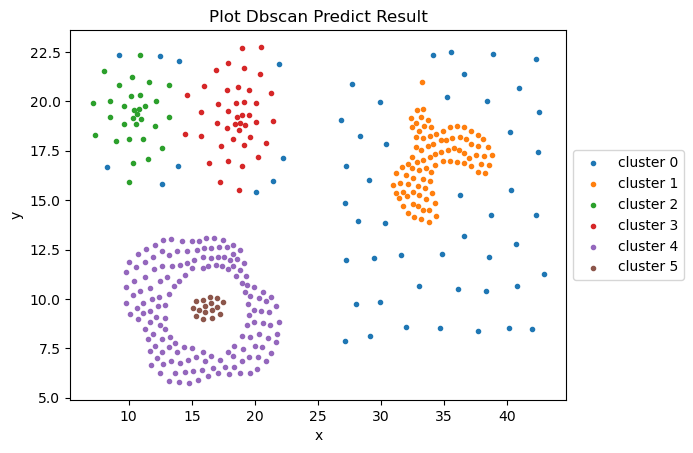

              precision    recall  f1-score   support

           1       0.82      0.98      0.89        47
           2       0.99      1.00      0.99        92
           3       1.00      0.82      0.90        38
           4       0.98      0.91      0.94        45
           5       1.00      1.00      1.00       158
           6       1.00      1.00      1.00        16

    accuracy                           0.97       396
   macro avg       0.96      0.95      0.95       396
weighted avg       0.97      0.97      0.97       396



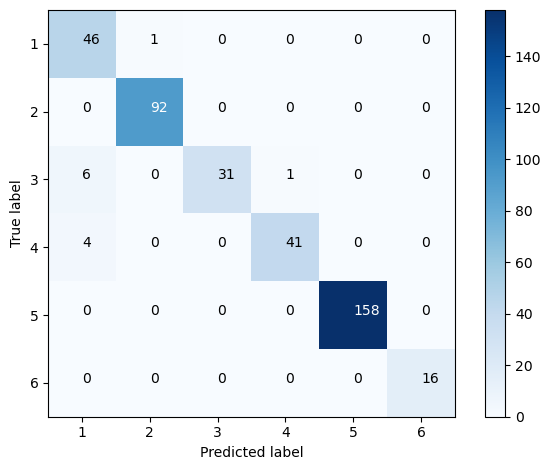

In [10]:
def getDBSCAN_improvement(vectors, epsilon, minPoints):
    #initilize all pointlable to unassigned cluster as 0
    pred_label  = [unassigned_cluster] * len(vectors)
    point_neighbors = []
    #initilize list for core/noncore point
    corepoint=[]
    noncore=[]
    #adding KD tree method to build index structure for data
    kd = KDTree(vectors)
    #Find all neigbor for all point
    for i in range(len(vectors)):
        #lower the complexity from O(n2) to O(n)
        points = kd.query_ball_point(vectors[i], epsilon)
        point_neighbors.append(points)
    #print('point_neighbors',point_neighbors)   
    #Find all core point, borderpoint and noise
    for i in range(len(point_neighbors)):
        # if points in circle are more than min points, it is the core point
        if (len(point_neighbors[i])>=minPoints):
            pred_label[i]=core # label the core point as -1
            corepoint.append(i)
        else:
            noncore.append(i)
    # scan the values in all temporally noncore array that includes lower than minpoints points. 
    # If any of the values is a core point, that means the point correlated to noncore array is a border point for another core point 
    for i in noncore:
        for j in point_neighbors[i]:
            if j in corepoint:
                pred_label[i]=border # label the border point as -2, others are noise as initial 0 

                break
    #print(len(pred_label), 'pred_label',pred_label)      
    
    #start assigning point to cluster
    clusters = 1
    #Using a Queue to put all neigbor core point in queue and find neigbor's neigbor
    for i in range(len(pred_label)):
        q = queue.Queue()
        if (pred_label[i] == core):
            pred_label[i] = clusters
            for x in point_neighbors[i]:
                # if the core point and neighbor point are all core point, put the neighbor point into queue
                # cluster neighbor point which is either another core point or a border point as same cluster as its core point
                if(pred_label[x]==core):
                    #print('x', x)
                    q.put(x)
                    pred_label[x]=clusters
                elif(pred_label[x]==border):
                    pred_label[x]=clusters
                    
            #Stop when all point in Queue has been checked   
            while not q.empty():
                out_point = q.get() # first in first out, reduce the complexity, here out_point is x and y we put previously until no core point in the neighbors
                #print('out_point',out_point)
                neighbors = point_neighbors[out_point] 
                #print('neighbors', neighbors)
                for y in neighbors:
                    if (pred_label[y]==core):
                        pred_label[y]=clusters
                        q.put(y)
                    if (pred_label[y]==border):
                        pred_label[y]=clusters 
            #print(len(pred_label), 'pred_label 3', pred_label)
            clusters=clusters+1 #move to next cluster
           
    return pred_label,clusters

vectors = getData(df_noise)
epsilon = 1.5
minPoints = 5  
start = time.time()
pred_label,clusters = getDBSCAN_improvement(vectors,epsilon,minPoints)
end = time.time()
print(f'Improved DBSCAN based on KD tree computation time is {end - start}')
plotDBSCAN(vectors, pred_label, clusters)
getAccuracy(pred_label, getLabel(df_noise))

Compared the result of standard DBscan and improved DBscan based on KD Tree, the time complexity were lowered from 0.84s to 0.01s. The space complexity were changed from O(n2) to O(n) whereas the accuracy of two functions are still same. Thus, I'll use another dataset to compare the result again.

In [11]:
df_iris = pd.read_csv('iris.csv').drop('Id',axis=1).rename(columns={'Species':'label'})
le = preprocessing.LabelEncoder()
df_iris['label'] = le.fit_transform(df_iris.label.values)+1
df_iris

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,label
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,3
146,6.3,2.5,5.0,1.9,3
147,6.5,3.0,5.2,2.0,3
148,6.2,3.4,5.4,2.3,3


Standard DBSCAN computation time is 0.12203598022460938
              precision    recall  f1-score   support

           1       0.06      0.02      0.03        50
           2       0.00      0.00      0.00        50
           3       0.48      0.80      0.60        50

    accuracy                           0.27       150
   macro avg       0.18      0.27      0.21       150
weighted avg       0.18      0.27      0.21       150

accuracy score None


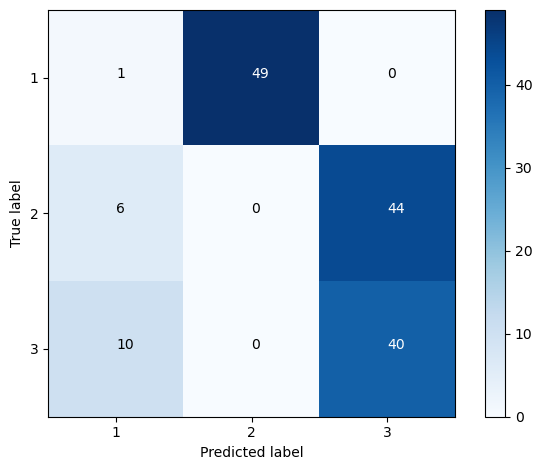

In [12]:
vectors = getData(df_iris)
epsilon = 0.5
minPoints = 5
start = time.time()
pred_label,clusters = getDBSCAN(vectors,epsilon,minPoints)
end = time.time()
print(f'Standard DBSCAN computation time is {end - start}')
score = getAccuracy(pred_label, getLabel(df_iris))
print('accuracy score', score)

Improved DBSCAN based on KD tree computation time is 0.005014181137084961
              precision    recall  f1-score   support

           1       0.06      0.02      0.03        50
           2       0.00      0.00      0.00        50
           3       0.48      0.80      0.60        50

    accuracy                           0.27       150
   macro avg       0.18      0.27      0.21       150
weighted avg       0.18      0.27      0.21       150

accuracy score None


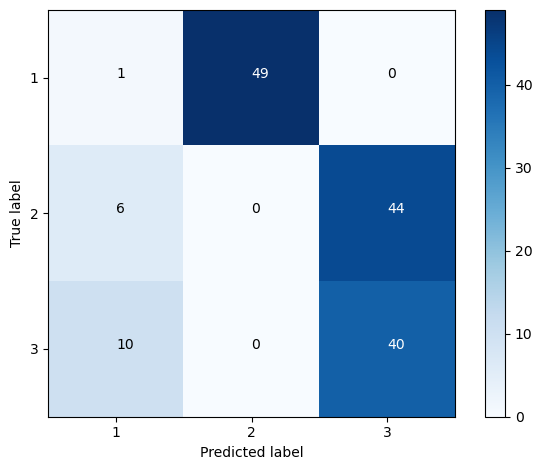

In [13]:
vectors = getData(df_iris)
epsilon = 0.5
minPoints = 5
start = time.time()
pred_label,clusters = getDBSCAN_improvement(vectors,epsilon,minPoints)
end = time.time()
print(f'Improved DBSCAN based on KD tree computation time is {end - start}')
score = getAccuracy(pred_label, getLabel(df_iris))
print('accuracy score', score)

In the Iris dataste with 4 dimensional still doesn't show a better accuracy. But the computation time was lowered a lot more than previous 2 dimensional dataset from 0.12s to 0.005s. This also approves that the KD tree method has a better performance in high dimensional dataset.